In [9]:
import warnings
warnings.filterwarnings("ignore")

from collections import Counter, ChainMap
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import utilities.helpers as hp
import pprint
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

plt.style.use(style='seaborn')
%matplotlib inline
sns.set()


# Unknown Homeland cases EDA:

# Import data set:


Below we see the shape of the whole dataset.


In [10]:
pd.options.mode.chained_assignment = None

df_full = hp.import_dataset(encoding='utf-8')
# Convert json to csv:
# df_full.to_csv('../data/dk_asylum_data_1.csv', encoding='utf-8', index=False)
df_full.shape


(9635, 5)

# Dataset preprocessing:

Cases of Unknown Homeland (Ukendt hjemland) are kept.

Below we see the shape and head of the dataset.


In [11]:
df_UH = df_full[df_full.country == "Ukendt hjemland"]

# Drop redundant column:
df_UH.drop('hasText', axis=1, inplace=True)

df = df_UH

df["text"] = df["text"].astype("string")

df.shape

(192, 4)

In [12]:
df.head()

,id,asylum_motive,country,text
287,287,[Etniske forhold],Ukendt hjemland,Nævnet stadfæstede i november 2021 Udl...
515,515,"[Kriminelle forhold, Militære forhold]",Ukendt hjemland,Nævnet stadfæstede i juni 2021 Udlændi...
551,551,"[Sur Place, LGBT, Politiske forhold, Etnisk...",Ukendt hjemland,Nævnet stadfæstede i juni 2021 Udlændi...
989,989,"[Agents of Persecution, Anden kønsrelateret f...",Ukendt hjemland,Nævnet stadfæstede i december 2020 Udl...
1379,1379,"[Militære forhold, Nationalitet]",Ukendt hjemland,Nævnet hjemviste i juni 2020 Udlænding...


Check for potential duplicates and drop them:


In [13]:
duplicates_df = df[df.duplicated(['text'], keep=False)]
#pd.concat(g for _, g in df.groupby("text") if len(g) > 1)

# See all duplicates:
duplicates_df


,id,asylum_motive,country,text
1421,1421,"[Inddragelse/forlængelse, Religiøse forhold, ...",Ukendt hjemland,Nævnet stadfæstede i maj 2020 Udlændin...
1440,1440,"[Inddragelse/forlængelse, Religiøse forhold, ...",Ukendt hjemland,Nævnet stadfæstede i maj 2020 Udlændin...
4102,4102,"[Politiske forhold, Generelle forhold]",Ukendt hjemland,Nævnet stadfæstede i januar 2018 Udlæn...
4103,4103,"[Privatretlig forhold, Generelle forhold]",Ukendt hjemland,Nævnet stadfæstede i januar 2018 Udlæn...
4157,4157,"[Nationalitet, Generelle forhold, Udrejsefor...",Ukendt hjemland,Nævnet stadfæstede i januar 2018 Udlæn...
4160,4160,[Emneord:],Ukendt hjemland,Nævnet stadfæstede i januar 2018 Udlæn...


In [14]:
# Drop duplicates from original dataframe based on text column
# If the summary is the same probalbly were are looking at a duplicate
# without taking into account all other variables(columns):
df = df.drop_duplicates('text', keep='last')

# Check shape again:
df.shape


(189, 4)

## Length of texts

Create a numeric column in order to get a feel about the length of the texts.


In [15]:
df['length'] = df['text'].str.len()

df.describe().T


,count,mean,std,min,25%,50%,75%,max
id,189.0,3296.661376,1225.330399,287.0,2632.0,3128.0,3933.0,7295.0
length,189.0,5008.539683,2046.292952,1104.0,3532.0,4753.0,6057.0,13105.0


## Boxplot:


<AxesSubplot:>

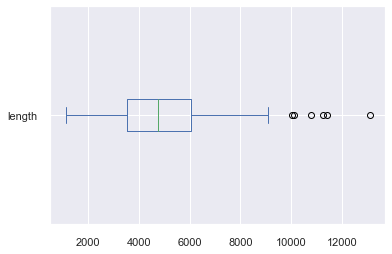

In [16]:
# Box plot:
df['length'].plot(kind='box', vert=False)


# Create a pipeline:


The pipeline consists of the following steps:

- Lowercase all characters
- Drop numbers
- Remove punctuation
- Remove stopwords. The list of stopwords can be found [here](https://github.com/jethronap/AsylumData_KU/blob/main/misc/stopwords_dk.txt).
- Single letter words are dropped, too.
- Tokenization
- Lemmatization. The process during which all words are turned into its roots.

Steps can be added or removed from the pipeline.


In [17]:
pipeline = [str.lower, hp.remove_punctuation, hp.remove_stopwords, hp.drop_single_letter_words,
            hp.tokenize, hp.lemmatize]


def process(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens


In [18]:
# Apply the process pipeline:
df['tokens'] = df['text'].apply(process, pipeline=pipeline)

# Add column to see the number of tokens:
df['num_tokens'] = df['tokens'].map(len)


In [19]:
df.head()


,id,asylum_motive,country,text,length,tokens,num_tokens
287,287,[Etniske forhold],Ukendt hjemland,Nævnet stadfæstede i november 2021 Udl...,4753,"[stadfæste, 2021, udlændingestyrels, afgørelse...",325
515,515,"[Kriminelle forhold, Militære forhold]",Ukendt hjemland,Nævnet stadfæstede i juni 2021 Udlændi...,3149,"[stadfæste, 2021, udlændingestyrels, afgørelse...",219
551,551,"[Sur Place, LGBT, Politiske forhold, Etnisk...",Ukendt hjemland,Nævnet stadfæstede i juni 2021 Udlændi...,4433,"[stadfæste, 2021, udlændingestyrels, afgørelse...",318
989,989,"[Agents of Persecution, Anden kønsrelateret f...",Ukendt hjemland,Nævnet stadfæstede i december 2020 Udl...,2664,"[stadfæste, 2020, udlændingestyrels, afgørelse...",184
1379,1379,"[Militære forhold, Nationalitet]",Ukendt hjemland,Nævnet hjemviste i juni 2020 Udlænding...,4626,"[hjemvise, 2020, udlændingestyrels, afgørelse,...",324


# Analysis:


## Exploratory descriptive analysis (EDA):


## Decision extraction:


In [20]:
df['tokens_joined'] = [' '.join(token) for token in df['tokens']]


In [21]:

# df_stad = df['tokens_joined'].str.contains('stadfæste', regex=True)
# df_hem = df['tokens_joined'].str.contains('hjemvise', regex=True)
# df_med = df['tokens_joined'].str.contains('meddele', regex=True)

# # df['decision'] = np.where(df_stad & (df_hem | df_med), "check", np.nan)
# df['decision'] = np.where((df_hem | df_med) & df_stad, "denied", np.where(
#     df_hem | df_med, "overturned", np.where(df_stad, "denied", np.nan)))

# affirmed decision of Immigration Services
df_stad = df['tokens_joined'].str.contains('stadfæst.*?', regex=True)
# overturned decision of Immigration Services
df_hem = df['tokens_joined'].str.contains('hjemvis.*?', regex=True)
# overturned decision of Immigration Services
df_med = df['tokens_joined'].str.contains('meddel.*?', regex=True)
# overturned decision of Immigration Services
df_omg = df['tokens_joined'].str.contains('omgjor.*?|omgør.*?', regex=True)
# overturned decision of Immigration Services
df_ame = df['tokens_joined'].str.contains('ændr.*?', regex=True)
# overturned decision of Immigration Services
df_oph = df['tokens_joined'].str.contains('ophæv.*?', regex=True)

df['decision'] = np.where(df_stad, 'affirmed', np.where(
    df_hem | df_med | df_omg | df_ame | df_oph, 'overturned', np.nan))


Plot decision outcomes:


Text(0, 0.5, 'outcomes')

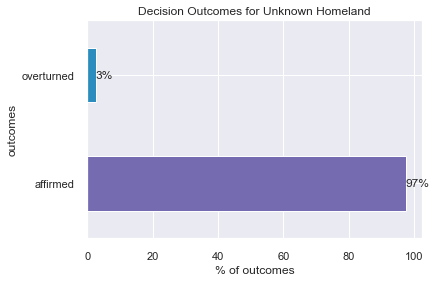

In [22]:
colors = ['#756bb1', '#2b8cbe']

# Plot with normalized values:
ax = df['decision'].value_counts(normalize=True).mul(100).round(1).plot(
    kind='barh', color=colors, title='Decision Outcomes for Unknown Homeland')

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%')
ax.set_xlabel('% of outcomes')
ax.set_ylabel('outcomes')

# Uncomment to plot frequencies:
# ax = df['decision'].value_counts().plot(
#     kind='barh', color=colors, title='Decision Outcomes for Unknown Homeland')
# ax.bar_label(container)


## Year extraction:


In [23]:
df['year'] = df['tokens'].str[1]


Plot decision outcomes by year:


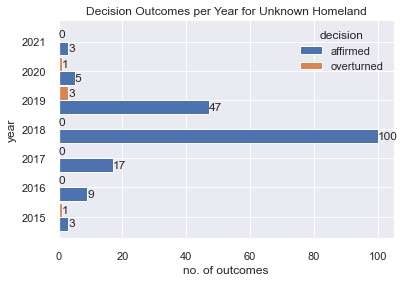

In [24]:
ax = df.groupby(['year'])['decision'].value_counts().unstack().plot(
    kind='barh', title='Decision Outcomes per Year for Unknown Homeland', width=0.95)

ax.set_xlabel('no. of outcomes')
ax.set_ylabel('year')

for container in ax.containers:
    ax.bar_label(container)


## Gender of applicants extraction:


In [25]:
male_pat = 'mandl.*?statsborg.*?|mand.*?ansøg.*?|mand.*?klag.*?'
female_pat = 'kvinde.*?statsborg.*?|kvinde.*?ansøg.*?|kvinde.*?klag.*?'

df_female = df['text'].str.contains(female_pat)
df_male = df['text'].str.contains(male_pat)

df['gender'] = np.where(df_male, "male", np.where(
    df_female, "female", "unidentified"))


Plot gender distribution:

NOTE: unidentified means that the regex pattern used does not fully yield the expected results.


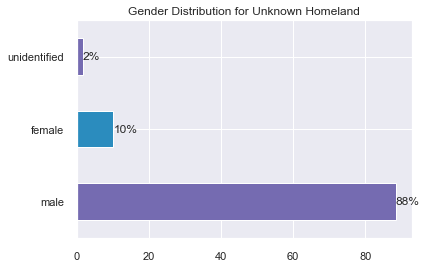

In [26]:
# Plot with normalized values:
ax = df['gender'].value_counts(normalize=True).mul(100).round(1).plot(
    kind='barh', color=colors, title='Gender Distribution for Unknown Homeland')

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%')


Plot decision outcome rate by gender:


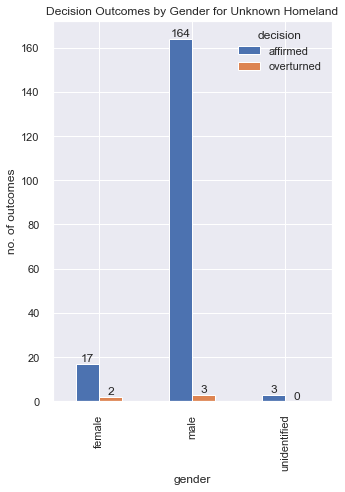

In [27]:
ax = df.groupby(['gender'])['decision'].value_counts().unstack().plot(
    kind='bar', title='Decision Outcomes by Gender for Unknown Homeland', figsize=(5, 7))
ax.set_xlabel('gender')
ax.set_ylabel('no. of outcomes')

for container in ax.containers:
    ax.bar_label(container)


Plot Decision Outcome Frequencies by Gender for each Year:


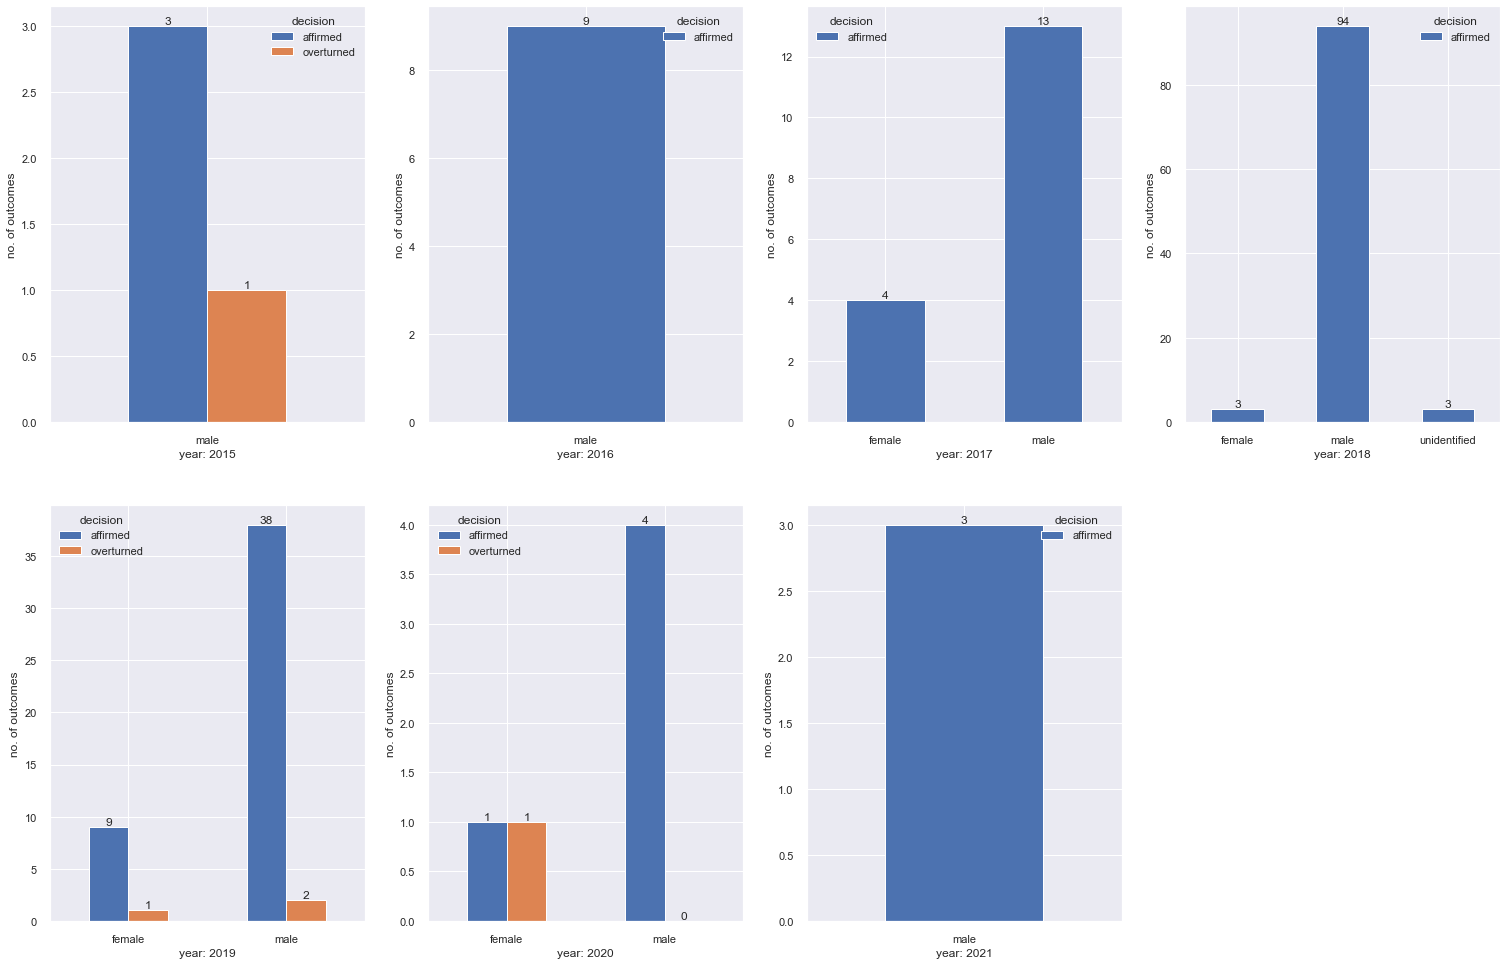

In [28]:
# Uncomment to plot separate figures:
# for year in df['year'].unique():
#     ax = df[df.year==year].groupby(['gender'])['decision'].value_counts().unstack().plot(
#     kind='bar', title='Decision Outcomes by Gender for Unknown Homeland for '+ str(year))
#     ax.set_xlabel('gender')
#     ax.set_ylabel('no. of outcomes')

#     for container in ax.containers:
#         ax.bar_label(container)

# Plot all figures in one:
plt.figure(figsize=(26, 26))
for ix, (key, group) in enumerate(df.groupby('year')):
    ax = plt.subplot(3, 4, ix+1)
    group.groupby('gender')['decision'].value_counts(
    ).unstack().plot(kind='bar', rot=0, ax=ax)
    ax.set_xlabel('year: {}'.format(key))
    ax.set_ylabel('no. of outcomes')
    for container in ax.containers:
        ax.bar_label(container)


## Extract Country of Origin:


In [29]:
syria_pat = 'Syr.*?|damask*?'
irak_pat = 'Irak|irak'
kuwait_pat = 'Kuwait'
eritrea_pat = 'eritr.*?'
algeria_pat = 'alger.*?'
iran_pat = 'Iran'
myanmar_pat = 'minbya|myanmar'
sudan_pat = 'sudan'
somalia_pat = 'somalia'
georgien_pat = 'rusland.*?|tjetjen.*?|georg.*?'
gambia_pat = 'gambia'
afghan_pat = 'kabul|afghan.*?'
sahara_pat = '.*?sahara'
libya_pat = 'tripoli|libyen'
liberia_pat = 'Liberia'
palestine_pat = 'palæstinens.*?'
sierra_pat = 'sierra.*?leone'
etiopia_pat = 'etiopien'

df_syria = df['tokens_joined'].str.contains(syria_pat)
df_irak = df['tokens_joined'].str.contains(irak_pat)
df_kuwait = df['tokens_joined'].str.contains(kuwait_pat)
df_eritrea = df['tokens_joined'].str.contains(eritrea_pat)
df_algeria = df['tokens_joined'].str.contains(algeria_pat)
df_iran = df['tokens_joined'].str.contains(iran_pat)
df_myanmar = df['tokens_joined'].str.contains(myanmar_pat)
df_sudan = df['tokens_joined'].str.contains(sudan_pat)
df_somalia = df['tokens_joined'].str.contains(somalia_pat)
df_georgien = df['tokens_joined'].str.contains(georgien_pat)
df_gambia = df['tokens_joined'].str.contains(gambia_pat)
df_afghan = df['tokens_joined'].str.contains(afghan_pat)
df_sahara = df['tokens_joined'].str.contains(sahara_pat)
df_libya = df['tokens_joined'].str.contains(libya_pat)
df_liberia = df['tokens_joined'].str.contains(liberia_pat)
df_palestine = df['tokens_joined'].str.contains(palestine_pat)
df_sierra = df['tokens_joined'].str.contains(sierra_pat)
df_etiopia = df['tokens_joined'].str.contains(etiopia_pat)

df['origin'] = np.where(df_myanmar, 'myanmar', np.where(df_kuwait, 'kuwait',
                np.where(df_iran, 'iran', np.where(df_eritrea, 'eritrea', np.where(df_irak, 'irak',
                np.where(df_libya, 'libya', np.where(df_syria, 'syria', np.where(df_sudan, 'sudan',
                np.where(df_somalia, 'somalia', np.where(df_georgien, 'georgien', np.where(df_gambia, 'gambia',
                np.where(df_afghan, 'afghanistan', np.where(df_sahara, 'sahara', np.where(df_algeria, 'algiers',
                np.where(df_liberia, 'liberia', np.where(df_palestine, 'palestine',
                np.where(df_sierra, 'sierra leone', np.where(df_etiopia, 'etiopia', np.nan))))))))))))))))))


Plot distribution of origin:


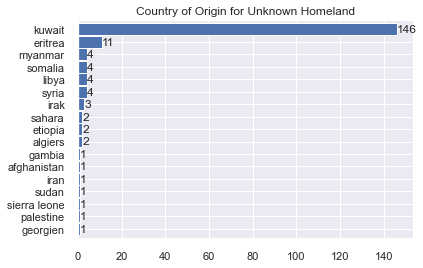

In [30]:
ax = df['origin'].value_counts().plot(
    kind='barh', title='Country of Origin for Unknown Homeland', width=0.95)
ax.invert_yaxis()
for container in ax.containers:
    ax.bar_label(container)


Plot decision outcome rate by origin:


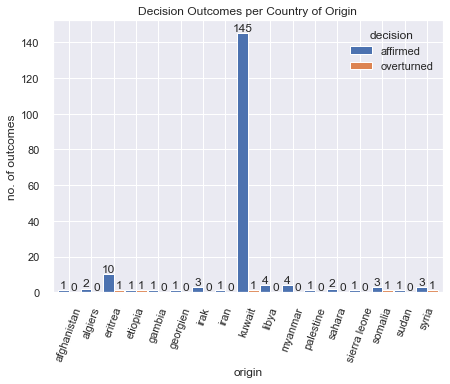

In [31]:
ax = df.groupby(df['origin'])['decision'].value_counts().unstack().plot(
    kind='bar', title='Decision Outcomes per Country of Origin', figsize=(7, 5), rot=70, width=0.95)
ax.set_xlabel('origin')
ax.set_ylabel('no. of outcomes')

for container in ax.containers:
    ax.bar_label(container)


# Asylum motives distribution:

In [32]:
df['asylum_motive'] = df['asylum_motive'].astype("string")

df_motives = df['asylum_motive'].str.split(',').explode().str.strip('[\'\'] ').value_counts()

df_motives


Generelle forhold                  125
Politiske forhold                   89
Nationalitet                        75
Etniske forhold                     53
Sagsoplysning                       16
Privatretlig forhold                14
Beviskrav og bevisvurdering         11
Udrejseforhold                       9
Agents of Persecution                8
Militære forhold                     6
Ægteskabelige forhold                6
Inddragelse/forlængelse              6
Tortur                               6
LGBT                                 4
Seksuelle forhold                    3
Chikane                              3
Kriminelle forhold                   3
Mindreårige                          2
Tilknyt bistand oprørsgruppe         2
Religiøse forhold                    2
Privatretlig konflikt                2
Sur Place                            2
Anden kønsrelateret forfølgelse      1
Overgreb                             1
To-instansbehandling                 1
Emneord:                 

Plot ten most frequent asylum motives:

Text(0, 0.5, 'frequency')

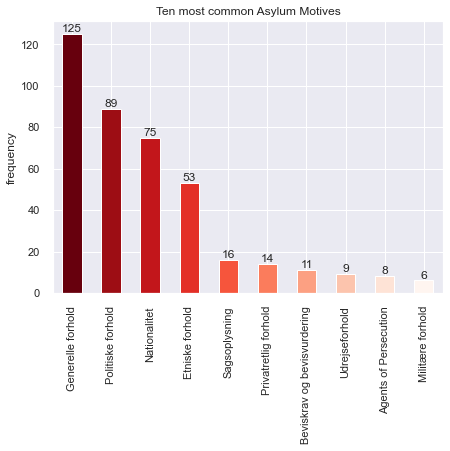

In [33]:
gradient_colors = cm.Reds(np.linspace(1, 0, 10))


ax = df_motives.iloc[:10].plot(kind='bar', color=gradient_colors,
                               rot=90, title='Ten most common Asylum Motives', figsize=(7, 5))

for container in ax.containers:
    ax.bar_label(container)
ax.set_ylabel('frequency')


# Set of locations referred in UH appeals:

In [34]:
# Create a DOC object from every row in pandas given column:
docs = list(hp.nlp.pipe(df['text']))

loci = []
for d in docs:
    # see set of locations:
    s=set(hp.get_locations(d))
    loci.append(s)

loci

[{('bangladesh', 'LOC'),
  ('damaskus', 'LOC'),
  ('danmark', 'LOC'),
  ('dhaka', 'LOC'),
  ('europa', 'LOC'),
  ('holland', 'LOC'),
  ('istanbul', 'LOC'),
  ('minbya', 'LOC'),
  ('myanmar', 'LOC'),
  ('rohingyaer', 'LOC'),
  ('singapore', 'LOC'),
  ('syrien', 'LOC')},
 {('algeriet', 'LOC'),
  ('algeriets', 'LOC'),
  ('algier', 'LOC'),
  ('casablanca', 'LOC'),
  ('danmark', 'LOC'),
  ('frankrig', 'LOC'),
  ('marokko', 'LOC'),
  ('sverige', 'LOC')},
 {('australien', 'LOC'),
  ('danmark', 'LOC'),
  ('juba', 'LOC'),
  ('south sudan', 'LOC'),
  ('sprogtests', 'LOC'),
  ('sudan', 'LOC'),
  ('sydsudan', 'LOC')},
 {('danmark', 'LOC'), ('kenya', 'LOC'), ('somalia', 'LOC')},
 {('eritrea', 'LOC'), ('etiopien', 'LOC'), ('sudan', 'LOC')},
 {('danmark', 'LOC'),
  ('europa', 'LOC'),
  ('holland', 'LOC'),
  ('iran', 'LOC'),
  ('kobala', 'LOC')},
 {('danmark', 'LOC'),
  ('eritrea', 'LOC'),
  ('etiopien', 'LOC'),
  ('italien', 'LOC'),
  ('libyen', 'LOC')},
 {('kuwait', 'LOC')},
 {('4.-17', 'LOC'),
  ('

# Distribution of Bidoon cases:

In [35]:
bidoon_pat = 'bidoon.*?'

df_biddons = df['tokens_joined'].str.contains(bidoon_pat)
df['bidoons'] = np.where(df_biddons, 'bidoon', 'other')


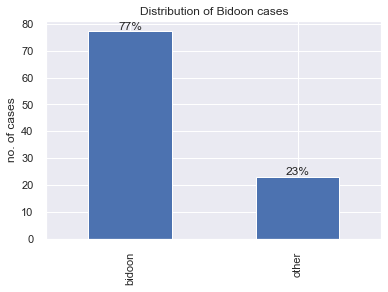

In [36]:
ax = df['bidoons'].value_counts(normalize=True).mul(100).round(1).plot(
    kind='bar', title='Distribution of Bidoon cases',)
# ax.set_xlabel('bidoon')
ax.set_ylabel('no. of cases')

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%')

Yearly distribution of Bidoon cases:

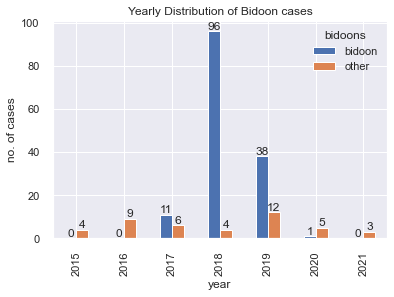

In [37]:
ax = df.groupby('year')['bidoons'].value_counts().unstack().plot(
    kind='bar', title='Yearly Distribution of Bidoon cases')
# ax.set_xlabel('bidoon')
ax.set_ylabel('no. of cases')

for container in ax.containers:
    ax.bar_label(container)

Decision outcome rate for Bidoon cases:

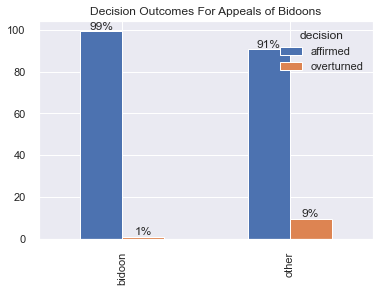

In [38]:
ax = df.groupby('bidoons')['decision'].value_counts(normalize=True).mul(100).round(1).unstack().plot(
    kind='bar', title='Decision Outcomes For Appeals of Bidoons')
ax.set_xlabel(' ')

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%')

## Search for specific keywords (terms):


Look for `last name (efternavn)`. See how many times are they referred to in the texts.


In [39]:
df['last_name'] = df['tokens_joined'].str.extract(
    r'(efternav.?)', hp.re.IGNORECASE)
df['last_name'].value_counts()


efternavn    12
Name: last_name, dtype: int64

In [40]:
# Look up `§7 stk. 2.` occurencies.

# df['law_articles'] = df['text'].str.extract(r'(§ 7.*?stk. 2.*?)')
# df['law_articles'].value_counts()

## Keyword in context (KWIC):

KWIC analysis produces a list of text fragments of equal length showing the left and right context of a keyword.


Check the context around `efternavn`. See all 18 context instances of term.


In [41]:
hp.kwic(df['text'], 'efternavn', print_samples=18) 

18 random samples out of 18 contexts for 'efternavn':
e myndigheder. Den kvindelige ansøger er ligeledes registreret som værende fra Irak og med et andet  efternavn  end meddelt de danske myndigheder. Den kvindelige ansøger har således indledningsvis til de danske 
tivet, jf. nærmere nedenfor – anses for påfaldende, at ansøgeren ved sin ankomst til Danmark brugte  efternavn et [AB], som også er hendes nuværende irakiske ægtefælles efternavn. Sprogtesten kan ikke føre til e
s egne oplysninger eller med oplysninger i familiens dokumenter, således at det alene er det sidste  efternavn , som adskiller sig. Disse personer har oplyst, at den mandlige ansøgers mor har boet i Irak. Hertil
ejse i Danmark over for de danske myndigheder oplyste, at de var irakiske statsborgere, og at deres  efternavn  var [et andet end oplyst af ansøgerne senere hen]. Ansøgerne er ikke fremkommet med en rimelig fork
er, at den kvindelige ansøger [F] ved indrejse i Grækenland er registreret som iraker med [et ande

Check context around `familie`. See ten random samples.

In [42]:
hp.kwic(df['text'], 'familie', print_samples=10)

10 random samples out of 601 contexts for 'familie':
e anholdt i forbindelse med demonstrationen, og der er ikke holdepunkter for at antage, at nogen af  familie medlemmerne har haft en central rolle i planlægningen eller udførelsen af hverken demonstrationen i 
 der ransagede deres bopæl, ikke bar våben, senere under samme samtale, da hun blev foreholdt andre  familie medlemmers forklaringer herom, at hun ikke kiggede på folkenes hænder. Under nævnsmødet har den kvin
else af andre grunde kan komme på tale. Efter klagerens kortvarige ophold i Danmark, hans manglende  familie mæssige tilknytning til Danmark, oplysningerne om hans meget begrænsede tilknytning til arbejdsmarke
nsmødet har forklaret, at hans familie ikke havde telefon, og at det var [A], der underrettede hans  familie  om ansøgerens skjulested. Den mandlige ansøgers forklaring om, at han ikke lyttede efter tolkens ov
llem Kuwait og Irak, og ansøgeren flyttede ind hos sin fars gode venindes familie. Ansøgeren kendte  famili

Bellow we apply KWIC for `stk` keyword found from the frequency analysis and print 10 random context appearances.

The call is made to the original untokenized & unprocessed dataset.


In [43]:
hp.kwic(df['text'], 'stk', print_samples=10)

10 random samples out of 363 contexts for 'stk':
 bestemt dato i] 1988 blev klageren meddelt opholdstilladelse efter udlændingelovens daværende § 7,  stk . 1, nr. 1. Opholdstil-ladelsen blev [på en nærmere bestemt dato i ] 1991 gjort tidsubegrænset.  Ved
orbud for bestandig efter udlændingelovens § 49, stk. 1, jf. § 22, nr. 1, nr. 2 og nr. 4, jf. § 32,  stk . 2, nr. 5, jf. stk. 1. [På et nærmere bestemt tidspunkt i] 2014 stadfæstede [landsretten] byrettens
ledes heller ikke, at betingelserne for opholdstilladelse efter udlændingelovens § 7, stk. 1, eller  stk . 2, er opfyldt, stadfæster Flygtningenævnet Udlændingestyrelsens afgørelse.” Hjem/2018/59/LMD   
jf. udlændingelovens § 7, stk. 1, eller har behov for beskyttelsesstatus, jf. udlændingelovens § 7,  stk . 2. Flygtningenævnet stadfæster derfor Udlændingestyrelsens afgørelse.” hjem/2018/27/MKT
 at inddrage klagerens opholdstilladelse i medfør af udlændingelovens § 19, stk. 2, nr. 1, og § 19,  stk . 7, 1. pkt., jf. § 26, stk. 1, idet

KWIC for `opholdstilladelse`.


In [44]:
hp.kwic(df['text'], 'opholdstilladelse', print_samples=10)

10 random samples out of 228 contexts for 'opholdstilladelse':
om den pågældende er omfattet af udlændingelovens § 7. Det følger heraf, at en udlænding, der søger  opholdstilladelse  efter udlændingelovens § 7, må sandsynliggøre den identitet og det asylgrundlag, udlændingen påberå
 identitet eller sit asylmotiv, og ansøgeren har således ikke sandsynliggjort, at betingelserne for  opholdstilladelse  efter udlændingelovens § 7, stk. 1, eller stk. 2, er opfyldt. Flygtningenævnet stadfæster derfor Ud
efter ikke, at ansøgeren har sandsynliggjort sin identitet eller asylmotiv, og at betingelserne for  opholdstilladelse  efter udlændingelovens § 7, stk. 1 eller stk. 2, er opfyldt. Flygtningenævnet stadfæster derfor Udl
 bidoons i Kuwait er således ikke af en sådan karakter, at dette i sig selv ville kunne føre til en  opholdstilladelse  i Danmark, og heller ikke oplysningerne om ansøgerens konkrete livsforhold indebærer efter oplysnin
 forhold, at ansøgeren har fremlagt dokumenter, der viser

KWIC for `§ 7` keyword.


In [45]:
hp.kwic(df['text'], '§ 7', print_samples=10)

10 random samples out of 368 contexts for '§ 7':
n tilbagevenden til hjemlandet vil risikere forfølgelse eller overgreb omfattet af udlændingelovens  § 7 , stk. 1 eller 2. Flygtningenævnet stadfæster derfor Udlændingestyrelsens afgørelse.” Hjem2019/7/SML
o for forfølgelse omfattet af udlændingelovens § 7, stk. 1, eller i risiko for overgreb omfattet af  § 7 , stk. 2. Flygtningenævnet stadfæster derfor Udlændingestyrelsens afgørelse.” Afgh/2019/24/MGO
kan gives. Det følger heraf, at en udlænding, der søger om opholdstilladelse efter udlændingelovens  § 7 , må sandsynliggøre sin identitet og det asylgrundlag, han eller hun påberåber sig. Flygtningenævnet
har sandsynliggjort sit asylmotiv. Betingelserne for opholdstilladelse i medfør af udlændingelovens  § 7 , stk. 1, eller stk. 2, er derfor ikke opfyldt. Flygtningenævnet stadfæster derfor Udlændingestyrels
ke de generelle forhold for bidooner i Kuwait kan begrunde opholdstilladelse efter udlændingelovens  § 7 .  Det fremgår af baggrundso

## Natural Language Processing:


## Frequency analysis:

Here the most frequent tokens in the **whole** corpus are counted.

The table below presents top ten words.


In [46]:
# See ten most frequent words in the whole corpus:
freq_df = hp.count_words(df)
freq_df.head(10)

# See all words with their frequencies:
# pd.value_counts(np.hstack(df['tokens']))


,freq
token,
ansøger,3630
Kuwait,1370
forklare,1237
oplyse,815
myndighed,796
mandlig,794
asylmotiv,749
forklaring,675
lægge,649


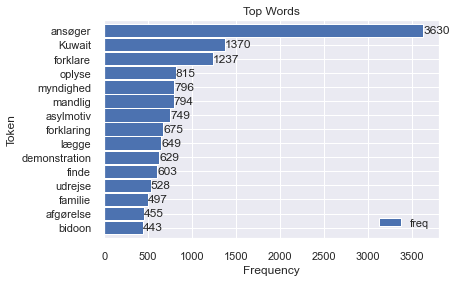

In [47]:
# Plot the results:
ax = freq_df.head(15).plot(kind='barh', width=0.95)
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

for container in ax.containers:
    ax.bar_label(container)


## N-gram analysis:


In [48]:
values = defaultdict(int)

# Get the count of every bigram in the data set from last processed column:
for text in df['tokens_joined']:
    for word in hp.generate_N_grams(text, 2):
        values[word] += 1


In [49]:
# Focus on more frequently occuring words.
# Sort in descending order with respect to the column of interest:
df_processed = pd.DataFrame(
    sorted(values.items(), key=lambda x: x[1], reverse=True))

# Ten first values of the first column:
c1 = df_processed[0][:10]
# Ten first values of the second column:
c2 = df_processed[1][:10]


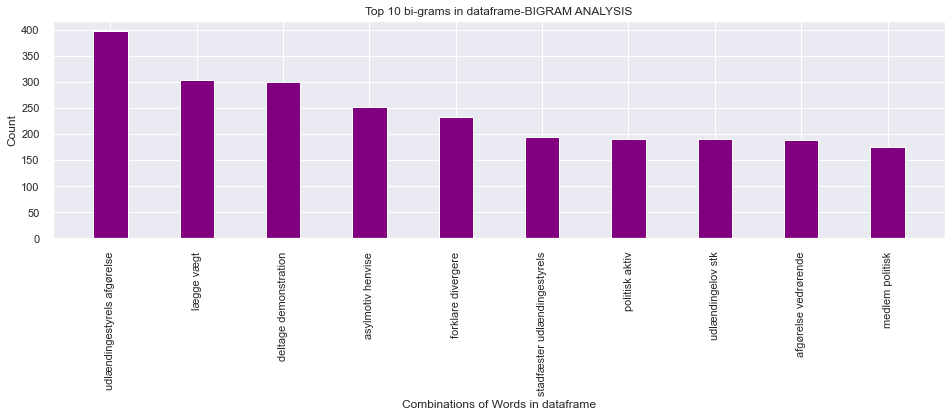

In [50]:
plt.figure(1, figsize=(16, 4))
plt.bar(c1, c2, color='purple',
        width=0.4)
plt.xlabel("Combinations of Words in dataframe")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Top 10 bi-grams in dataframe-BIGRAM ANALYSIS")
# plt.savefig("dataset-bigram.png")
plt.show()


## TF-IDF


Below is the shape of the resulting vector of the vocabulary created from the given context.


In [51]:
# Get the column of interest:
docs = df['tokens_joined'].tolist()

# Create a vocabulary of words:

cv = CountVectorizer()
word_count_vector = cv.fit_transform(docs)

# Get shape of resulting vector:
word_count_vector.shape


(189, 4312)

Ten random words from the vocabulary:


In [52]:
# Look at 10 words from our vocabulary:
list(cv.vocabulary_.keys())[:10]


['stadfæste',
 '2021',
 'udlændingestyrels',
 'afgørelse',
 'vedrørende',
 'mandlig',
 'statsborger',
 'ukendt',
 'hjemland',
 'indrejst']

Peek at the IDF values array:


In [53]:
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(word_count_vector)


# Peek at the IDF values:
tfidf_transformer.idf_


array([5.55387689, 5.55387689, 3.11152986, ..., 4.63758616, 5.55387689,
       3.35665231])

In [54]:
# We only need to do this once:
feature_names = cv.get_feature_names_out()

# Generate tf-idf for all documents in list. docs has 189 documents:
tf_idf_vector = tfidf_transformer.transform(cv.transform(docs))

results = []
for i in range(tf_idf_vector.shape[0]):

    # get vector for a single document
    curr_vector = tf_idf_vector[i]

    # sort the tf-idf vector by descending order of scores
    # tocoo() Return a COOrdinate representation of this matrix.
    sorted_items = hp.sort_coo(curr_vector.tocoo())

    # extract only the top n; n here is 10
    keywords = hp.extract_top_n_from_vector(feature_names, sorted_items, 10)

    results.append(keywords)

df_tfIDF = pd.DataFrame(zip(docs, results), columns=['doc', 'keywords'])
# df_tfIDF.shape
df_tfIDF

,doc,keywords
0,stadfæste 2021 udlændingestyrels afgørelse ved...,"{'myanmar': 0.398, 'rohingya': 0.298, 'ansøger..."
1,stadfæste 2021 udlændingestyrels afgørelse ved...,"{'algerium': 0.398, 'ansøger': 0.36, 'frankrig..."
2,stadfæste 2021 udlændingestyrels afgørelse ved...,"{'ansøger': 0.323, 'sudan': 0.291, '2020': 0.2..."
3,stadfæste 2020 udlændingestyrels afgørelse ved...,"{'somalia': 0.435, 'alshabaab': 0.419, 'kenya'..."
4,hjemvise 2020 udlændingestyrels afgørelse vedr...,"{'eritreisk': 0.402, 'eritrea': 0.352, 'etiopi..."
...,...,...
184,stadfæste 2016 udlændingestyrels afgørelse ved...,"{'fader': 0.475, 'liyu': 0.351, 'police': 0.30..."
185,stadfæste 2015 udlændingestyrels afgørelse ved...,"{'onlf': 0.436, 'police': 0.311, 'liyu': 0.311..."
186,hjemvise 2015 udlændingestyrels afgørelse vedr...,"{'etiopien': 0.197, 'hjemvise': 0.188, 'foreta..."
187,stadfæste 2015 udlændingestyrels afgørelse ved...,"{'soldat': 0.536, 'burmesisk': 0.216, 'burma':..."


Twenty most common words based on TF-IDF values


In [55]:
# Create a dictionary from results list of dictionaries:
my_dict = dict(ChainMap(*results))

c = Counter(my_dict)

# Returns top 20 most common pairs:
most_common = c.most_common(20)

# For getting the keys from `most_common`:
my_keys = [key for key, val in most_common]

# Add pretty printer:
pp = pprint.PrettyPrinter(indent=4)

pp.pprint(most_common)


[   ('klager', 0.81),
    ('officer', 0.644),
    ('taliban', 0.575),
    ('soldat', 0.536),
    ('libyen', 0.522),
    ('police', 0.497),
    ('liyu', 0.497),
    ('ægtefælle', 0.496),
    ('senegal', 0.472),
    ('tjetjenie', 0.472),
    ('georgien', 0.472),
    ('sierra', 0.466),
    ('leone', 0.466),
    ('libysk', 0.456),
    ('avis', 0.45),
    ('holland', 0.443),
    ('hær', 0.437),
    ('somalia', 0.435),
    ('ghanesisk', 0.433),
    ('bøde', 0.426)]


Plotting the pairs:


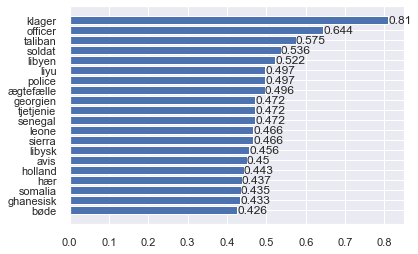

In [56]:
# plt.bar(range(len(most_common)), [val[1] for val in most_common], align='center')
# plt.xticks(range(len(most_common)), [val[0] for val in most_common])
# plt.xticks(rotation=70)

# sort values in tuple:
sorted_most_common = sorted(most_common, key=lambda x: x[1])

fig, ax = plt.subplots()
bars = ax.barh([val[0] for val in sorted_most_common], [val[1]
               for val in sorted_most_common])

ax.bar_label(bars)
plt.show()
